In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 
import glob
import nibabel as nb
import itertools
import json
import sys
import statsmodels.api as sm
from statsmodels.formula.api import ols

from scipy import stats
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder


%matplotlib inline

In [2]:
flatten = lambda l: [item for sublist in l for item in sublist]

In [5]:
base_dir = '/home/abhijit/Jyotirmay/my_thesis'
proj = 'full_bayesian'
model = 'v2'
dataset = 'KORA'
report_id = '10_1571866968.4002764'
sample_dir = f'{base_dir}/projects/{proj}/outs/{proj}_{dataset}_{model}/{proj}_{dataset}_{model}_predictions_{dataset}/*_samples/**'
mean_segs_dir = f'{base_dir}/projects/{proj}/outs/{proj}_{dataset}_{model}/{proj}_{dataset}_{model}_predictions_{dataset}/*_seg.nii.gz'
sample_paths = glob.glob(sample_dir)
mean_seg_paths = glob.glob(mean_segs_dir)
print(len(mean_seg_paths))
sample_paths.extend(mean_seg_paths)
print(len(sample_paths))

153
1683


In [6]:
sample_count_dict = {}
for r_id, sample in enumerate(sample_paths):
    print("\rProcessing {}/{}.".format(r_id, len(sample_paths)), end="")

    split_str = sample.split('/')[-1].split('.')[0]
    v_id = split_str.split('_')[0]
    sample_id = split_str.split('_')[-1]
    s_data = nb.load(sample).get_fdata()
    unique_vals, counts = np.unique(s_data, return_counts=True)
    if v_id not in sample_count_dict.keys():
        sample_count_dict[v_id] = {str(i)+'_spleen':None for i in range(10)}
        sample_count_dict[v_id].update({str(i)+'_liver':None for i in range(10)})
    if sample_id == 'seg':
        sample_count_dict[v_id]['seg_spleen'] = counts[2]
        sample_count_dict[v_id]['seg_liver'] = counts[1]
    else:
        sample_count_dict[v_id][str(sample_id)+'_liver'] = counts[2]    
        sample_count_dict[v_id][str(sample_id)+'_spleen'] = counts[1] 

print(sample_count_dict)
df = pd.DataFrame.from_dict(sample_count_dict, orient="index")
df.to_csv(f'./projects/{proj}/reports/{proj}_{dataset}_{model}/{dataset}/{report_id}_sample_count_report.csv', index_label='volume_id')


Processing 1682/1683.{'KORA2452967': {'0_spleen': 13603, '1_spleen': 13607, '2_spleen': 13358, '3_spleen': 13115, '4_spleen': 13364, '5_spleen': 13183, '6_spleen': 13742, '7_spleen': 13596, '8_spleen': 13839, '9_spleen': 13099, '0_liver': 111216, '1_liver': 110921, '2_liver': 111840, '3_liver': 110581, '4_liver': 110554, '5_liver': 110323, '6_liver': 110944, '7_liver': 112776, '8_liver': 110981, '9_liver': 110375, 'seg_spleen': 110171, 'seg_liver': 13092}, 'KORA2459526': {'0_spleen': 20517, '1_spleen': 20684, '2_spleen': 20845, '3_spleen': 20261, '4_spleen': 20847, '5_spleen': 21022, '6_spleen': 19993, '7_spleen': 20430, '8_spleen': 21223, '9_spleen': 20741, '0_liver': 187026, '1_liver': 186150, '2_liver': 186451, '3_liver': 183833, '4_liver': 185733, '5_liver': 186548, '6_liver': 187055, '7_liver': 186037, '8_liver': 181560, '9_liver': 184808, 'seg_spleen': 181600, 'seg_liver': 20389}, 'KORA2455268': {'0_spleen': 7093, '1_spleen': 6723, '2_spleen': 7070, '3_spleen': 7169, '4_spleen': 

In [7]:
df = pd.read_csv(f'./projects/{proj}/reports/{proj}_{dataset}_{model}/{dataset}/{report_id}_sample_count_report.csv')

In [11]:
# df_k_feats = pd.read_csv('./dataset_groups/whole_body_datasets/KORA/processsed_csv.csv')
# df_k_feats['volume_id'] = 'KORA' + df_k_feats['mrt-image-id'].astype(str)
# df_k_feats.to_csv('./dataset_groups/whole_body_datasets/KORA/processsed_csv_.csv')
df_k_feats = pd.read_csv('./dataset_groups/whole_body_datasets/KORA/processsed_csv_.csv')

In [12]:
df_reports = pd.read_csv(f'./projects/{proj}/reports/{proj}_{dataset}_{model}/{dataset}/{report_id}_report.csv')

In [13]:
df_merged = pd.merge(df, df_k_feats, how='inner', on=['volume_id'])
df_merged_final = pd.merge(df_merged, df_reports, how='inner', on=['volume_id'])
df_merged_final.to_csv(f'./projects/{proj}/reports/{proj}_{dataset}_{model}/{dataset}/{report_id}_concat_report_final.csv')

In [14]:
df = pd.read_csv(f'./projects/{proj}/reports/{proj}_{dataset}_{model}/{dataset}/{report_id}_concat_report_final.csv')

In [15]:
good_feats = ['bmi-who_normal', 'bmi-who_obesity class I', 'bmi-who_obesity class II', 'bmi-who_obesity class III',
             'hba1c-mmol/mol', 'cholesterol-hdl', 'age', 'blood-pressure-diastolic', 'blood-pressure-systolic',
             'sex', 'bmi-numeric']

smoking_feats = ['smoker_former', 'smoker_irregular', 'smoker_non-smoker', 'smoker_regular', 'smoking-packages']
bmi_feats = ['bmi-who_normal', 'bmi-who_obesity class I', 'bmi-who_obesity class II', 'bmi-who_obesity class III',
            'bmi-numeric', 'bmi-who_pre-obisety']
blood_pressure_feats = ['blood-pressure-diastolic', 'blood-pressure-systolic']
cholesterol_feats = ['cholesterol-hdl', 'cholesterol-ldl', 'cholesterol-total']
mri_feats = ['mri-liver-fat-artifacts', 'mri-liver-fat-lobus-dexter', 
             'mri-liver-fat-lobus-sinister', 'mri-liver-fat-portal-vein']
alcohol_feats = ['alcohol-g/day']
hbalc_feats = ['hba1c-mmol/mol', 'hba1c-percentage']
medication_feats = ['meds-antidiabetic', 'meds-antihypertensive', 'meds-incretin-mimetics', 'meds-insulin-therapy',
                    'meds-lipoprotein-lowering', 'meds-oral-antidiabetic']
triglyceride = ['triglyceride']
hypertension = ['hypertension']
basic_feats = ['age', 'height', 'sex', 'weight' ]
vols_feat = ['seg_liver', 'seg_spleen']

In [16]:
all_feats = [basic_feats, smoking_feats, bmi_feats, blood_pressure_feats, cholesterol_feats, 
             mri_feats, alcohol_feats, hbalc_feats, medication_feats, triglyceride, hypertension, vols_feat]
feats = flatten(all_feats)
df = df.fillna(0)
p_values = {}
y = df["diabetes_status"].copy()
y_classes = np.argmax(pd.get_dummies(y).values, axis=1)
# print(y_classes, pd.get_dummies(y).values)
for f in feats:
    try:
        X = pd.get_dummies(df.loc[y.index, [f]], drop_first=True)
#         X = X.fillna(0)
        mod = sm.OLS(y_classes, X)
        fii = mod.fit()
#         print(fii.summary())
#         print(f, fii.pvalues.values[0])
        p_values[f] = {'coeff': fii.params.values[0], 'p_value':fii.pvalues.values[0]}
    except Exception as e:
        print(e)
p_value_df = pd.DataFrame.from_dict(p_values, orient="index")
p_value_df

/home/abhijit/anaconda3/envs/tenv/lib/python3.6/site-packages/statsmodels/base/model.py:1294: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse


,coeff,p_value
age,0.008857,1.232938e-15
height,0.002735,8.371145e-14
sex,0.615385,4.480111e-14
weight,0.006076,5.552860e-17
smoker_former,0.514706,1.934475e-07
smoker_irregular,0.333333,2.394919e-01
smoker_non-smoker,0.423077,2.523419e-04
smoker_regular,0.500000,3.555895e-03
smoking-packages,0.014308,1.977551e-05
bmi-who_normal,0.190476,1.460153e-01


In [17]:

p_value_df.to_csv(f'./projects/{proj}/reports/{proj}_{dataset}_{model}/{dataset}/{report_id}_p_values.csv', index_label='feats')
        

In [18]:
categorical_features = ['diabetes_status']
for f in categorical_features:
    dfDummies = pd.get_dummies(df[f], prefix = f)
    df_c = pd.concat([df, dfDummies], axis=1)

In [19]:
all_feats4vols = [basic_feats, smoking_feats, bmi_feats, blood_pressure_feats, cholesterol_feats, 
             mri_feats, alcohol_feats, hbalc_feats, medication_feats, triglyceride, hypertension,
                  ['diabetes_status_0', 'diabetes_status_1', 'diabetes_status_2']]

feats = flatten(all_feats4vols)
df_c = df_c.fillna(0)
p_values = {}
y = df_c["seg_spleen"].copy()
y_classes = y.values #np.argmax(pd.get_dummies(y).values, axis=1)
for f in feats:
    try:
        X = pd.get_dummies(df_c.loc[y.index, [f]], drop_first=True)
#         X = X.fillna(0)
        mod = sm.OLS(y_classes, X)
        fii = mod.fit()
#         print(fii.summary())
#         print(f, fii.pvalues.values[0], fii.params.values)
        p_values[f] = {'coeff': fii.params.values[0], 'p_value':fii.pvalues.values[0]}
    except Exception as e:
        print(e)

# print(p_values)
p_value_df = pd.DataFrame.from_dict(p_values, orient="index")
p_value_df

,coeff,p_value
age,2372.006245,8.766970e-71
height,797.530168,2.917169e-88
sex,145825.351648,4.730684e-34
weight,1635.009128,2.306523e-101
smoker_former,139100.882353,6.184713e-20
smoker_irregular,131752.777778,5.155435e-03
smoker_non-smoker,135687.153846,7.706428e-14
smoker_regular,133635.208333,2.086993e-06
smoking-packages,4046.650959,1.869473e-14
bmi-who_normal,113415.476190,7.343159e-08


In [20]:
all_feats4vols = [basic_feats, smoking_feats, bmi_feats, blood_pressure_feats, cholesterol_feats, 
             mri_feats, alcohol_feats, hbalc_feats, medication_feats, triglyceride, hypertension,
                  ['diabetes_status_0', 'diabetes_status_1', 'diabetes_status_2']]

feats = flatten(all_feats4vols)
df_c = df_c.fillna(0)
p_values = {}
y = df_c["seg_liver"].copy()
y_classes = y.values #np.argmax(pd.get_dummies(y).values, axis=1)
for f in feats:
    try:
        X = pd.get_dummies(df_c.loc[y.index, [f]], drop_first=True)
#         print(X)
#         X = X.fillna(0)
        mod = sm.OLS(y_classes, X)
        fii = mod.fit()
#         print(fii.summary())
#         print(f, fii.pvalues.values[0], fii.params.values)
        p_values[f] = {'coeff': fii.params.values[0], 'p_value':fii.pvalues.values[0]}
    except Exception as e:
        print(e)

# print(p_values)
p_value_df = pd.DataFrame.from_dict(p_values, orient="index")
p_value_df

,coeff,p_value
age,270.430932,7.609011e-52
height,91.660254,4.042133e-62
sex,17609.648352,5.351296e-34
weight,188.310167,9.201317e-68
smoker_former,17015.132353,1.484954e-20
smoker_irregular,16966.444444,2.819709e-03
smoker_non-smoker,14637.903846,6.173966e-11
smoker_regular,13442.000000,9.455447e-05
smoking-packages,488.085880,2.112073e-14
bmi-who_normal,11302.928571,1.242256e-05


In [43]:
# all_feats4vols = [basic_feats, smoking_feats, bmi_feats, blood_pressure_feats, cholesterol_feats, 
#              mri_feats, alcohol_feats, hbalc_feats, medication_feats, triglyceride, hypertension, ['diabetes_status']]

mod_s = []
all_feats_simple = [['age', 'sex'],['diabetes_status_0', 'diabetes_status_1', 'diabetes_status_2'],['height', 'weight']]
all_feats_simple1 = [['age', 'sex'],['diabetes_status_0', 'diabetes_status_1', 'diabetes_status_2'],['bmi-numeric']]
all_feats_simple2 = [['age', 'sex'],['diabetes_status_0', 'diabetes_status_1', 'diabetes_status_2'],['height', 'weight', 'bmi-numeric']]
all_feats_simple3 = [['diabetes_status_0', 'diabetes_status_1', 'diabetes_status_2']]
for feats_list in [all_feats_simple1]:
    feats = flatten(feats_list)
    df_c = df_c.fillna(0)
    p_values = {}
    for target in ['seg_liver', 'seg_spleen']:
        print(target)
        for i in range(2):
            
            y = df_c[target].copy()
    #         print(y.values)
    #         y_classes = np.argmax(pd.get_dummies(y).values, axis=1)
            y_classes = y.values
            if i==0:
                continue
                print('iou as multiplier')
                target_prefix = target.split('_')[1]
                ious = df_c['iou_'+target_prefix].values
#                 print(y_classes[0:10], ious[0:10])
                y_classes = np.multiply(y_classes, ious)
#                 print(y_classes[0:10])
    #         print(y_classes)
            try:
                print(feats)
                X = pd.get_dummies(df_c.loc[y.index, feats], drop_first=True)
            #         X = X.fillna(0)
                mod = sm.OLS(y_classes, X)
                mod_ = ols("y_classes ~ X", df_c).fit()
                mod_s.append(mod_)
                table = sm.stats.anova_lm(mod_) # Type 2 Anova DataFrame
                print('------------------------------------------------------------')
                print(table)
                fii = mod.fit()
                print(fii.summary())
                df_fii = pd.read_html(fii.summary().tables[1].as_html(),header=0,index_col=0)[0]
#                 print(df_fii)
            #         print(f, fii.pvalues.values[0], fii.params.values)
                p_values[f] = {'coeff': fii.params.values, 'p_value':fii.pvalues.values}
            except Exception as e:
                print(e)

# full_table = sm.stats.anova_lm(mod_s) # Type 2 Anova DataFrame
# print(full_table)
# print(p_values)
# p_value_df = pd.DataFrame.from_dict(p_values, orient="index")
# p_value_df

seg_liver
['age', 'sex', 'diabetes_status_0', 'diabetes_status_1', 'diabetes_status_2', 'bmi-numeric']
------------------------------------------------------------
             df        sum_sq       mean_sq         F    PR(>F)
X           6.0  1.730922e+09  2.884870e+08  6.908649  0.000002
Residual  147.0  6.138333e+09  4.175737e+07       NaN       NaN
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.219
Model:                            OLS   Adj. R-squared:                  0.193
Method:                 Least Squares   F-statistic:                     8.267
Date:                Mon, 28 Oct 2019   Prob (F-statistic):           6.60e-07
Time:                        13:48:15   Log-Likelihood:                -1556.4
No. Observations:                 153   AIC:                             3125.
Df Residuals:                     147   BIC:                             3143.
Df Model:   

In [44]:
df_c.rename(columns={'bmi-numeric':'bmi_numeric'}, 
                 inplace=True)

In [45]:
mod_liver = ols('seg_liver ~ age + sex + bmi_numeric + diabetes_status_0 + diabetes_status_1 + diabetes_status_2'
           , df_c).fit()
mod_spleen = ols('seg_spleen ~ age + sex + bmi_numeric + diabetes_status_0 + diabetes_status_1 + diabetes_status_2'
           , df_c).fit()

In [46]:

full_table = sm.stats.anova_lm(mod_liver) # Type 2 Anova DataFrame
print(full_table)

                      df        sum_sq       mean_sq          F    PR(>F)
age                  1.0  3.152370e+08  3.152370e+08   7.537649  0.006802
sex                  1.0  8.701796e+08  8.701796e+08  20.806909  0.000011
bmi_numeric          2.0  5.674951e+08  2.837476e+08   6.784703  0.001522
diabetes_status_0    1.0  7.805886e+05  7.805886e+05   0.018665  0.891520
diabetes_status_1    1.0  4.743393e+06  4.743393e+06   0.113420  0.736768
diabetes_status_2    1.0  9.921460e+05  9.921460e+05   0.023723  0.877804
Residual           146.0  6.105963e+09  4.182167e+07        NaN       NaN


In [47]:

full_table = sm.stats.anova_lm(mod_spleen) # Type 2 Anova DataFrame
print(full_table)

                      df        sum_sq       mean_sq          F        PR(>F)
age                  1.0  1.291136e+10  1.291136e+10  12.503350  5.447295e-04
sex                  1.0  1.897163e+10  1.897163e+10  18.372114  3.283445e-05
bmi_numeric          2.0  6.290283e+10  3.145142e+10  30.457530  8.809173e-12
diabetes_status_0    1.0  1.309013e+09  1.309013e+09   1.267647  2.620559e-01
diabetes_status_1    1.0  4.719671e+07  4.719671e+07   0.045705  8.310107e-01
diabetes_status_2    1.0  1.490650e+08  1.490650e+08   0.144354  7.045420e-01
Residual           146.0  1.507643e+11  1.032632e+09        NaN           NaN


In [28]:
df_normal = df[df['diabetes_status']==0]
df_pre_diabetic = df[df['diabetes_status']==1]
df_diabetic = df[df['diabetes_status']==2]

Text(0, 0.5, 'Dice Score')

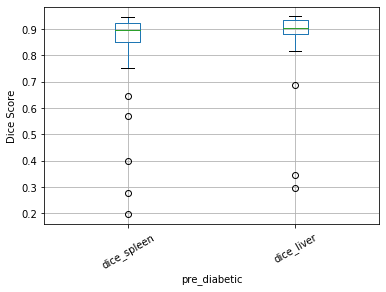

In [29]:
boxplot = df_pre_diabetic[['dice_spleen', 'dice_liver']].boxplot(rot=30)
boxplot.set_xlabel("pre_diabetic")
boxplot.set_ylabel("Dice Score")

Text(0, 0.5, 'Dice Score')

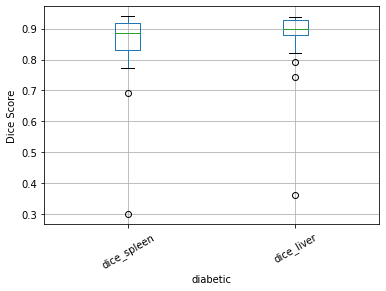

In [30]:
boxplot = df_diabetic[['dice_spleen', 'dice_liver']].boxplot(rot=30)
boxplot.set_xlabel("diabetic")
boxplot.set_ylabel("Dice Score")

Text(0, 0.5, 'Dice Score')

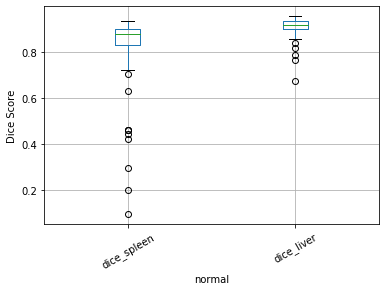

In [31]:
boxplot = df_normal[['dice_spleen', 'dice_liver']].boxplot(rot=30)
boxplot.set_xlabel("normal")
boxplot.set_ylabel("Dice Score")

In [32]:

df_normal_affx = df_normal.rename(columns=lambda x: 'normal_'+x)
df_pre_diabetic_affx = df_pre_diabetic.rename(columns=lambda x: 'pre_diabetic_'+x)
df_diabetic_affx = df_diabetic.rename(columns=lambda x: 'diabetic_'+x)
dfs = pd.concat([df_normal_affx, df_pre_diabetic_affx, df_diabetic_affx])

/home/abhijit/anaconda3/envs/tenv/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  after removing the cwd from sys.path.


normal_dice_spleen vs pre_diabetic_dice_spleen
t: 0.2175091935780126
p: 0.8281474014546129


normal_dice_spleen vs diabetic_dice_spleen
t: -0.25985955062521127
p: 0.7954288392432425


pre_diabetic_dice_spleen vs diabetic_dice_spleen
t: -0.3409131229878441
p: 0.7345694582174971


normal_dice_liver vs pre_diabetic_dice_liver
t: 2.859713427724535
p: 0.004930424480865988


normal_dice_liver vs diabetic_dice_liver
t: 2.947032041149397
p: 0.003873354525378932


pre_diabetic_dice_liver vs diabetic_dice_liver
t: 0.023862766461980576
p: 0.9810551979832804




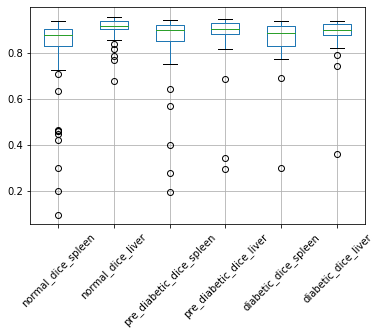

In [33]:
dfs[['normal_dice_spleen', 'normal_dice_liver', 'pre_diabetic_dice_spleen', 'pre_diabetic_dice_liver', 'diabetic_dice_spleen', 'diabetic_dice_liver']].boxplot(rot=45)

t,p = stats.ttest_ind(dfs['normal_dice_spleen'].dropna().values, dfs[ 'pre_diabetic_dice_spleen'].dropna().values)
print('normal_dice_spleen vs pre_diabetic_dice_spleen')
print('t:', t)
print('p:', p)
print('\n')

t,p = stats.ttest_ind(dfs['normal_dice_spleen'].dropna().values, dfs[ 'diabetic_dice_spleen'].dropna().values)
print('normal_dice_spleen vs diabetic_dice_spleen')
print('t:', t)
print('p:', p)
print('\n')

t,p = stats.ttest_ind(dfs['pre_diabetic_dice_spleen'].dropna().values, dfs[ 'diabetic_dice_spleen'].dropna().values)
print('pre_diabetic_dice_spleen vs diabetic_dice_spleen')
print('t:', t)
print('p:', p)
print('\n')

t,p = stats.ttest_ind(dfs['normal_dice_liver'].dropna().values, dfs[ 'pre_diabetic_dice_liver'].dropna().values)
print('normal_dice_liver vs pre_diabetic_dice_liver')
print('t:', t)
print('p:', p)
print('\n')

t,p = stats.ttest_ind(dfs['normal_dice_liver'].dropna().values, dfs[ 'diabetic_dice_liver'].dropna().values)
print('normal_dice_liver vs diabetic_dice_liver')
print('t:', t)
print('p:', p)
print('\n')

t,p = stats.ttest_ind(dfs['pre_diabetic_dice_liver'].dropna().values, dfs[ 'diabetic_dice_liver'].dropna().values)
print('pre_diabetic_dice_liver vs diabetic_dice_liver')
print('t:', t)
print('p:', p)
print('\n')

normal_iou_spleen vs pre_diabetic_iou_spleen
t: -0.8025181166653164
p: 0.42369584401124194


normal_iou_spleen vs diabetic_iou_spleen
t: -0.17383958408891523
p: 0.86229195631005


pre_diabetic_iou_spleen vs diabetic_iou_spleen
t: 0.3835223026161834
p: 0.7029267034175897


normal_iou_liver vs pre_diabetic_iou_liver
t: 2.7637664651452116
p: 0.006530983926667339


normal_iou_liver vs diabetic_iou_liver
t: 3.070595550209334
p: 0.002656593126834161


pre_diabetic_iou_liver vs diabetic_iou_liver
t: 0.4771266890095197
p: 0.6353102220666753




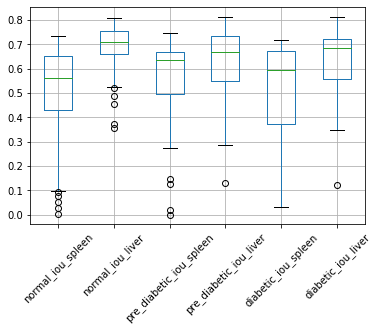

In [34]:
dfs[['normal_iou_spleen', 'normal_iou_liver', 'pre_diabetic_iou_spleen', 'pre_diabetic_iou_liver', 'diabetic_iou_spleen', 'diabetic_iou_liver']].boxplot(rot=45)

t,p = stats.ttest_ind(dfs['normal_iou_spleen'].dropna().values, dfs[ 'pre_diabetic_iou_spleen'].dropna().values)
print('normal_iou_spleen vs pre_diabetic_iou_spleen')
print('t:', t)
print('p:', p)
print('\n')

t,p = stats.ttest_ind(dfs['normal_iou_spleen'].dropna().values, dfs[ 'diabetic_iou_spleen'].dropna().values)
print('normal_iou_spleen vs diabetic_iou_spleen')
print('t:', t)
print('p:', p)
print('\n')

t,p = stats.ttest_ind(dfs['pre_diabetic_iou_spleen'].dropna().values, dfs[ 'diabetic_iou_spleen'].dropna().values)
print('pre_diabetic_iou_spleen vs diabetic_iou_spleen')
print('t:', t)
print('p:', p)
print('\n')

t,p = stats.ttest_ind(dfs['normal_iou_liver'].dropna().values, dfs[ 'pre_diabetic_iou_liver'].dropna().values)
print('normal_iou_liver vs pre_diabetic_iou_liver')
print('t:', t)
print('p:', p)
print('\n')

t,p = stats.ttest_ind(dfs['normal_iou_liver'].dropna().values, dfs[ 'diabetic_iou_liver'].dropna().values)
print('normal_iou_liver vs diabetic_iou_liver')
print('t:', t)
print('p:', p)
print('\n')

t,p = stats.ttest_ind(dfs['pre_diabetic_iou_liver'].dropna().values, dfs[ 'diabetic_iou_liver'].dropna().values)
print('pre_diabetic_iou_liver vs diabetic_iou_liver')
print('t:', t)
print('p:', p)
print('\n')

normal_surface_distance_prtogt_spleen vs pre_diabetic_surface_distance_prtogt_spleen
t: 0.2423937913917833
p: 0.8088512553907116


normal_surface_distance_prtogt_spleen vs diabetic_surface_distance_prtogt_spleen
t: 0.6559954118709463
p: 0.5131150620807889


pre_diabetic_surface_distance_prtogt_spleen vs diabetic_surface_distance_prtogt_spleen
t: 0.31889887635704456
p: 0.7511056552002746


normal_surface_distance_prtogt_liver vs pre_diabetic_surface_distance_prtogt_liver
t: 3.0404648517089683
p: 0.0028493825706220706


normal_surface_distance_prtogt_liver vs diabetic_surface_distance_prtogt_liver
t: 2.4057995688938933
p: 0.017703327583397422


pre_diabetic_surface_distance_prtogt_liver vs diabetic_surface_distance_prtogt_liver
t: -0.1581432830016305
p: 0.8749684166724767




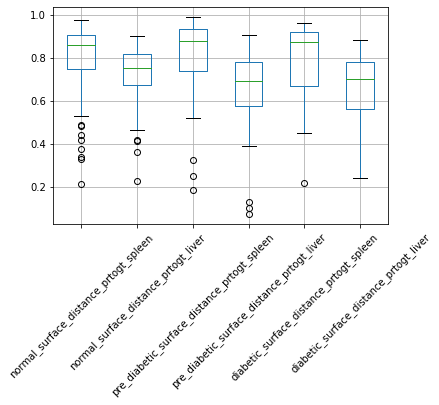

In [35]:
dfs[['normal_surface_distance_prtogt_spleen', 'normal_surface_distance_prtogt_liver', 'pre_diabetic_surface_distance_prtogt_spleen', 'pre_diabetic_surface_distance_prtogt_liver', 'diabetic_surface_distance_prtogt_spleen', 'diabetic_surface_distance_prtogt_liver']].boxplot(rot=45)

t,p = stats.ttest_ind(dfs['normal_surface_distance_prtogt_spleen'].dropna().values, dfs[ 'pre_diabetic_surface_distance_prtogt_spleen'].dropna().values)
print('normal_surface_distance_prtogt_spleen vs pre_diabetic_surface_distance_prtogt_spleen')
print('t:', t)
print('p:', p)
print('\n')

t,p = stats.ttest_ind(dfs['normal_surface_distance_prtogt_spleen'].dropna().values, dfs[ 'diabetic_surface_distance_prtogt_spleen'].dropna().values)
print('normal_surface_distance_prtogt_spleen vs diabetic_surface_distance_prtogt_spleen')
print('t:', t)
print('p:', p)
print('\n')

t,p = stats.ttest_ind(dfs['pre_diabetic_surface_distance_prtogt_spleen'].dropna().values, dfs[ 'diabetic_surface_distance_prtogt_spleen'].dropna().values)
print('pre_diabetic_surface_distance_prtogt_spleen vs diabetic_surface_distance_prtogt_spleen')
print('t:', t)
print('p:', p)
print('\n')

t,p = stats.ttest_ind(dfs['normal_surface_distance_prtogt_liver'].dropna().values, dfs[ 'pre_diabetic_surface_distance_prtogt_liver'].dropna().values)
print('normal_surface_distance_prtogt_liver vs pre_diabetic_surface_distance_prtogt_liver')
print('t:', t)
print('p:', p)
print('\n')

t,p = stats.ttest_ind(dfs['normal_surface_distance_prtogt_liver'].dropna().values, dfs[ 'diabetic_surface_distance_prtogt_liver'].dropna().values)
print('normal_surface_distance_prtogt_liver vs diabetic_surface_distance_prtogt_liver')
print('t:', t)
print('p:', p)
print('\n')

t,p = stats.ttest_ind(dfs['pre_diabetic_surface_distance_prtogt_liver'].dropna().values, dfs[ 'diabetic_surface_distance_prtogt_liver'].dropna().values)
print('pre_diabetic_surface_distance_prtogt_liver vs diabetic_surface_distance_prtogt_liver')
print('t:', t)
print('p:', p)
print('\n')

normal_surface_distance_gttopr_spleen vs pre_diabetic_surface_distance_gttopr_spleen
t: 0.039030002558121335
p: 0.9689254366354534


normal_surface_distance_gttopr_spleen vs diabetic_surface_distance_gttopr_spleen
t: 0.0771421198695696
p: 0.9386422507700786


pre_diabetic_surface_distance_gttopr_spleen vs diabetic_surface_distance_gttopr_spleen
t: 0.03173588175687453
p: 0.9748065555901295


normal_surface_distance_gttopr_liver vs pre_diabetic_surface_distance_gttopr_liver
t: 2.6943231510725876
p: 0.00797004382662886


normal_surface_distance_gttopr_liver vs diabetic_surface_distance_gttopr_liver
t: 2.8475732516086953
p: 0.00520504081974322


pre_diabetic_surface_distance_gttopr_liver vs diabetic_surface_distance_gttopr_liver
t: 0.2621616417467976
p: 0.79425285292734




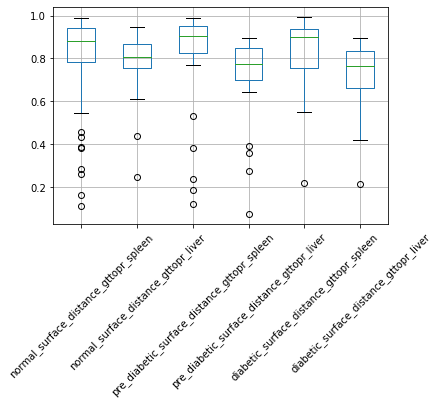

In [36]:
dfs[['normal_surface_distance_gttopr_spleen', 'normal_surface_distance_gttopr_liver', 'pre_diabetic_surface_distance_gttopr_spleen', 'pre_diabetic_surface_distance_gttopr_liver', 'diabetic_surface_distance_gttopr_spleen', 'diabetic_surface_distance_gttopr_liver']].boxplot(rot=45)

t,p = stats.ttest_ind(dfs['normal_surface_distance_gttopr_spleen'].dropna().values, dfs[ 'pre_diabetic_surface_distance_gttopr_spleen'].dropna().values)
print('normal_surface_distance_gttopr_spleen vs pre_diabetic_surface_distance_gttopr_spleen')
print('t:', t)
print('p:', p)
print('\n')

t,p = stats.ttest_ind(dfs['normal_surface_distance_gttopr_spleen'].dropna().values, dfs[ 'diabetic_surface_distance_gttopr_spleen'].dropna().values)
print('normal_surface_distance_gttopr_spleen vs diabetic_surface_distance_gttopr_spleen')
print('t:', t)
print('p:', p)
print('\n')

t,p = stats.ttest_ind(dfs['pre_diabetic_surface_distance_gttopr_spleen'].dropna().values, dfs[ 'diabetic_surface_distance_gttopr_spleen'].dropna().values)
print('pre_diabetic_surface_distance_gttopr_spleen vs diabetic_surface_distance_gttopr_spleen')
print('t:', t)
print('p:', p)
print('\n')

t,p = stats.ttest_ind(dfs['normal_surface_distance_gttopr_liver'].dropna().values, dfs[ 'pre_diabetic_surface_distance_gttopr_liver'].dropna().values)
print('normal_surface_distance_gttopr_liver vs pre_diabetic_surface_distance_gttopr_liver')
print('t:', t)
print('p:', p)
print('\n')

t,p = stats.ttest_ind(dfs['normal_surface_distance_gttopr_liver'].dropna().values, dfs[ 'diabetic_surface_distance_gttopr_liver'].dropna().values)
print('normal_surface_distance_gttopr_liver vs diabetic_surface_distance_gttopr_liver')
print('t:', t)
print('p:', p)
print('\n')

t,p = stats.ttest_ind(dfs['pre_diabetic_surface_distance_gttopr_liver'].dropna().values, dfs[ 'diabetic_surface_distance_gttopr_liver'].dropna().values)
print('pre_diabetic_surface_distance_gttopr_liver vs diabetic_surface_distance_gttopr_liver')
print('t:', t)
print('p:', p)
print('\n')

normal_surface_distance_avg_spleen vs pre_diabetic_surface_distance_avg_spleen
t: 0.13797789004377065
p: 0.8904681489368943


normal_surface_distance_avg_spleen vs diabetic_surface_distance_avg_spleen
t: 0.361673096333744
p: 0.7182486748318081


diabetic_surface_distance_avg_spleen vs pre_diabetic_surface_distance_avg_spleen
t: -0.17435546966659057
p: 0.8622764047954283


normal_surface_distance_avg_liver vs pre_diabetic_surface_distance_avg_liver
t: 2.999705739972961
p: 0.003231239311366333


normal_surface_distance_avg_liver vs diabetic_surface_distance_avg_liver
t: 2.738068509589902
p: 0.007146433698168384


diabetic_surface_distance_avg_liver vs pre_diabetic_surface_distance_avg_liver
t: -0.04332035946781083
p: 0.9656153289398919




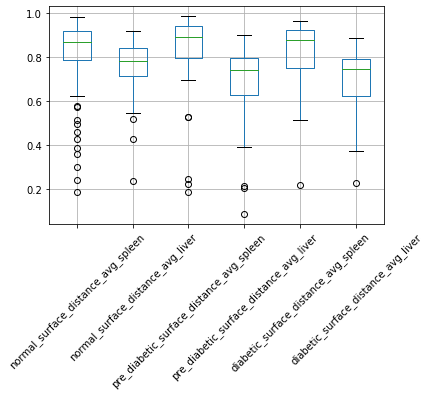

In [37]:
dfs[['normal_surface_distance_avg_spleen', 'normal_surface_distance_avg_liver', 'pre_diabetic_surface_distance_avg_spleen', 'pre_diabetic_surface_distance_avg_liver', 'diabetic_surface_distance_avg_spleen', 'diabetic_surface_distance_avg_liver']].boxplot(rot=45)

t,p = stats.ttest_ind(dfs['normal_surface_distance_avg_spleen'].dropna().values, dfs[ 'pre_diabetic_surface_distance_avg_spleen'].dropna().values)

print('normal_surface_distance_avg_spleen vs pre_diabetic_surface_distance_avg_spleen')
print('t:', t)
print('p:', p)
print('\n')

t,p = stats.ttest_ind(dfs['normal_surface_distance_avg_spleen'].dropna().values, dfs[ 'diabetic_surface_distance_avg_spleen'].dropna().values)
print('normal_surface_distance_avg_spleen vs diabetic_surface_distance_avg_spleen')
print('t:', t)
print('p:', p)
print('\n')

t,p = stats.ttest_ind(dfs['diabetic_surface_distance_avg_spleen'].dropna().values, dfs[ 'pre_diabetic_surface_distance_avg_spleen'].dropna().values)
print('diabetic_surface_distance_avg_spleen vs pre_diabetic_surface_distance_avg_spleen')
print('t:', t)
print('p:', p)
print('\n')

t,p = stats.ttest_ind(dfs['normal_surface_distance_avg_liver'].dropna().values, dfs[ 'pre_diabetic_surface_distance_avg_liver'].dropna().values)
print('normal_surface_distance_avg_liver vs pre_diabetic_surface_distance_avg_liver')
print('t:', t)
print('p:', p)
print('\n')

t,p = stats.ttest_ind(dfs['normal_surface_distance_avg_liver'].dropna().values, dfs[ 'diabetic_surface_distance_avg_liver'].dropna().values)
print('normal_surface_distance_avg_liver vs diabetic_surface_distance_avg_liver')
print('t:', t)
print('p:', p)
print('\n')

t,p = stats.ttest_ind(dfs['diabetic_surface_distance_avg_liver'].dropna().values, dfs[ 'pre_diabetic_surface_distance_avg_liver'].dropna().values)
print('diabetic_surface_distance_avg_liver vs pre_diabetic_surface_distance_avg_liver')
print('t:', t)
print('p:', p)
print('\n')


normal_dice_mean vs pre_diabetic_dice_mean
t: 1.2548748118116169
p: 0.21174143395559913


normal_dice_mean vs diabetic_dice_mean
t: 0.8031917182926284
p: 0.4234926205896644


diabetic_dice_mean vs pre_diabetic_dice_mean
t: 0.21303023051004458
p: 0.832152651816187




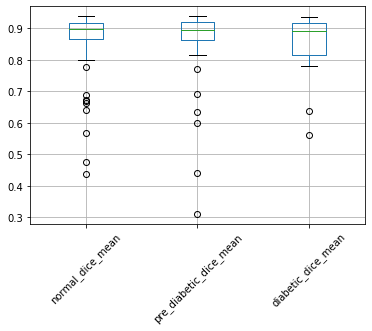

In [38]:
# dfs[['normal_iou_mean', 'normal_dice_mean', 'pre_diabetic_iou_mean', 'pre_diabetic_dice_mean', 'diabetic_iou_mean', 'diabetic_dice_mean']].boxplot(rot=45)
dfs[[ 'normal_dice_mean', 'pre_diabetic_dice_mean', 'diabetic_dice_mean']].boxplot(rot=45)

# dfs['normal_dice_mean'].dropna().values



t,p = stats.ttest_ind(dfs['normal_dice_mean'].dropna().values, dfs[ 'pre_diabetic_dice_mean'].dropna().values)

print('normal_dice_mean vs pre_diabetic_dice_mean')
print('t:', t)
print('p:', p)
print('\n')

t,p = stats.ttest_ind(dfs['normal_dice_mean'].dropna().values, dfs[ 'diabetic_dice_mean'].dropna().values)
print('normal_dice_mean vs diabetic_dice_mean')
print('t:', t)
print('p:', p)
print('\n')

t,p = stats.ttest_ind(dfs['diabetic_dice_mean'].dropna().values, dfs[ 'pre_diabetic_dice_mean'].dropna().values)
print('diabetic_dice_mean vs pre_diabetic_dice_mean')
print('t:', t)
print('p:', p)
print('\n')


normal_ged vs pre_diabetic_ged
t: -1.1158629803343934
p: 0.26650804128719424


diabetic_ged vs pre_diabetic_ged
t: -0.15747761052367448
p: 0.8754902830790747


normal_ged vs diabetic_ged
t: -0.7589438418975596
p: 0.44941241957157785


normal_sncc vs pre_diabetic_sncc
t: -0.28659439649563584
p: 0.774872248945623


normal_sncc vs diabetic_sncc
t: -1.7660565764045293
p: 0.07999463204892536


pre_diabetic_sncc vs diabetic_sncc
t: -1.2882106176932484
p: 0.20348671202077245




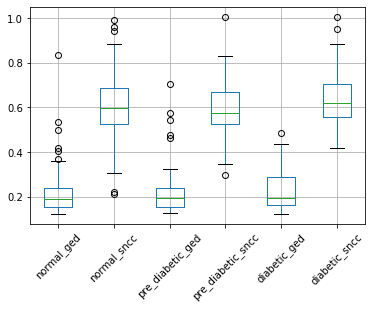

In [39]:
dfs[['normal_ged', 'normal_sncc', 'pre_diabetic_ged', 'pre_diabetic_sncc', 'diabetic_ged', 'diabetic_sncc']].boxplot(rot=45)

t,p = stats.ttest_ind(dfs['normal_ged'].dropna().values, dfs[ 'pre_diabetic_ged'].dropna().values)

print('normal_ged vs pre_diabetic_ged')
print('t:', t)
print('p:', p)
print('\n')

t,p = stats.ttest_ind(dfs['diabetic_ged'].dropna().values, dfs[ 'pre_diabetic_ged'].dropna().values)
print('diabetic_ged vs pre_diabetic_ged')
print('t:', t)
print('p:', p)
print('\n')

t,p = stats.ttest_ind(dfs['normal_ged'].dropna().values, dfs[ 'diabetic_ged'].dropna().values)
print('normal_ged vs diabetic_ged')
print('t:', t)
print('p:', p)
print('\n')

t,p = stats.ttest_ind(dfs['normal_sncc'].dropna().values, dfs[ 'pre_diabetic_sncc'].dropna().values)
print('normal_sncc vs pre_diabetic_sncc')
print('t:', t)
print('p:', p)
print('\n')

t,p = stats.ttest_ind(dfs['normal_sncc'].dropna().values, dfs[ 'diabetic_sncc'].dropna().values)
print('normal_sncc vs diabetic_sncc')
print('t:', t)
print('p:', p)
print('\n')

t,p = stats.ttest_ind(dfs['pre_diabetic_sncc'].dropna().values, dfs[ 'diabetic_sncc'].dropna().values)
print('pre_diabetic_sncc vs diabetic_sncc')
print('t:', t)
print('p:', p)
print('\n')

normal_seg_spleen vs pre_diabetic_seg_spleen
t: -2.792701159987534
p: 0.0060044898302712485


normal_seg_spleen vs diabetic_seg_spleen
t: -2.852449552175127
p: 0.00513103455738067


diabetic_seg_spleen vs pre_diabetic_seg_spleen
t: 0.0823065252189942
p: 0.934725153204707


normal_seg_liver vs pre_diabetic_seg_liver
t: -0.8177259246438738
p: 0.4149872974066231


normal_seg_liver vs diabetic_seg_liver
t: -1.3170690710458173
p: 0.19038918753533707


diabetic_seg_liver vs pre_diabetic_seg_liver
t: 0.6343207247427082
p: 0.528706717637409




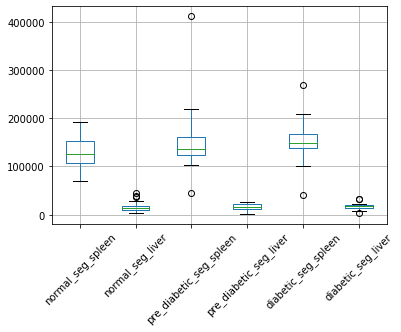

In [40]:
dfs[['normal_seg_spleen', 'normal_seg_liver', 'pre_diabetic_seg_spleen', 'pre_diabetic_seg_liver', 'diabetic_seg_spleen', 'diabetic_seg_liver']].boxplot(rot=45)

t,p = stats.ttest_ind(dfs['normal_seg_spleen'].dropna().values, dfs[ 'pre_diabetic_seg_spleen'].dropna().values)

print('normal_seg_spleen vs pre_diabetic_seg_spleen')
print('t:', t)
print('p:', p)
print('\n')

t,p = stats.ttest_ind(dfs['normal_seg_spleen'].dropna().values, dfs[ 'diabetic_seg_spleen'].dropna().values)
print('normal_seg_spleen vs diabetic_seg_spleen')
print('t:', t)
print('p:', p)
print('\n')

t,p = stats.ttest_ind(dfs['diabetic_seg_spleen'].dropna().values, dfs[ 'pre_diabetic_seg_spleen'].dropna().values)
print('diabetic_seg_spleen vs pre_diabetic_seg_spleen')
print('t:', t)
print('p:', p)
print('\n')

t,p = stats.ttest_ind(dfs['normal_seg_liver'].dropna().values, dfs[ 'pre_diabetic_seg_liver'].dropna().values)
print('normal_seg_liver vs pre_diabetic_seg_liver')
print('t:', t)
print('p:', p)
print('\n')

t,p = stats.ttest_ind(dfs['normal_seg_liver'].dropna().values, dfs[ 'diabetic_seg_liver'].dropna().values)
print('normal_seg_liver vs diabetic_seg_liver')
print('t:', t)
print('p:', p)
print('\n')

t,p = stats.ttest_ind(dfs['diabetic_seg_liver'].dropna().values, dfs[ 'pre_diabetic_seg_liver'].dropna().values)
print('diabetic_seg_liver vs pre_diabetic_seg_liver')
print('t:', t)
print('p:', p)
print('\n')

normal_seg_spleen vs pre_diabetic_seg_spleen
t: -2.792701159987534
p: 0.0060044898302712485


normal_seg_spleen vs diabetic_seg_spleen
t: -2.852449552175127
p: 0.00513103455738067


diabetic_seg_spleen vs pre_diabetic_seg_spleen
t: 0.0823065252189942
p: 0.934725153204707


normal_seg_liver vs pre_diabetic_seg_liver
t: -0.8177259246438738
p: 0.4149872974066231


normal_seg_liver vs diabetic_seg_liver
t: -1.3170690710458173
p: 0.19038918753533707


diabetic_seg_liver vs pre_diabetic_seg_liver
t: 0.6343207247427082
p: 0.528706717637409




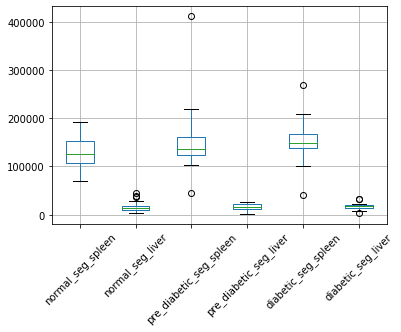

In [48]:
dfs[['normal_seg_spleen', 'normal_seg_liver', 'pre_diabetic_seg_spleen', 'pre_diabetic_seg_liver', 'diabetic_seg_spleen', 'diabetic_seg_liver']].boxplot(rot=45)

t,p = stats.ttest_ind(dfs['normal_seg_spleen'].dropna().values, dfs[ 'pre_diabetic_seg_spleen'].dropna().values)

print('normal_seg_spleen vs pre_diabetic_seg_spleen')
print('t:', t)
print('p:', p)
print('\n')

t,p = stats.ttest_ind(dfs['normal_seg_spleen'].dropna().values, dfs[ 'diabetic_seg_spleen'].dropna().values)
print('normal_seg_spleen vs diabetic_seg_spleen')
print('t:', t)
print('p:', p)
print('\n')

t,p = stats.ttest_ind(dfs['diabetic_seg_spleen'].dropna().values, dfs[ 'pre_diabetic_seg_spleen'].dropna().values)
print('diabetic_seg_spleen vs pre_diabetic_seg_spleen')
print('t:', t)
print('p:', p)
print('\n')

t,p = stats.ttest_ind(dfs['normal_seg_liver'].dropna().values, dfs[ 'pre_diabetic_seg_liver'].dropna().values)
print('normal_seg_liver vs pre_diabetic_seg_liver')
print('t:', t)
print('p:', p)
print('\n')

t,p = stats.ttest_ind(dfs['normal_seg_liver'].dropna().values, dfs[ 'diabetic_seg_liver'].dropna().values)
print('normal_seg_liver vs diabetic_seg_liver')
print('t:', t)
print('p:', p)
print('\n')

t,p = stats.ttest_ind(dfs['diabetic_seg_liver'].dropna().values, dfs[ 'pre_diabetic_seg_liver'].dropna().values)
print('diabetic_seg_liver vs pre_diabetic_seg_liver')
print('t:', t)
print('p:', p)
print('\n')

In [41]:
dfs['normal_seg_spleen_iou'] = dfs['normal_seg_spleen'] * dfs['normal_iou_spleen']
dfs['normal_seg_liver_iou'] = dfs['normal_seg_liver'] * dfs['normal_iou_liver']
dfs['pre_diabetic_seg_spleen_iou'] = dfs['pre_diabetic_seg_spleen'] * dfs['pre_diabetic_iou_spleen']
dfs['pre_diabetic_seg_liver_iou'] = dfs['pre_diabetic_seg_liver'] * dfs['pre_diabetic_iou_liver']
dfs['diabetic_seg_spleen_iou'] = dfs['diabetic_seg_spleen'] * dfs['diabetic_iou_spleen']
dfs['diabetic_seg_liver_iou'] = dfs['diabetic_seg_liver'] * dfs['diabetic_iou_liver']


normal_seg_spleen_iou vs pre_diabetic_seg_spleen_iou
t: -1.4404213204044496
p: 0.15211592981626995


normal_seg_spleen_iou vs diabetic_seg_spleen_iou
t: -1.2409213446768999
p: 0.21711721592475855


pre_diabetic_seg_spleen_iou vs diabetic_seg_spleen_iou
t: -0.02653853173564166
p: 0.97893137372492


normal_seg_liver_iou vs pre_diabetic_seg_liver_iou
t: 0.1106696825841675
p: 0.9120463786029969


normal_seg_liver_iou vs diabetic_seg_liver_iou
t: -0.07686096885477586
p: 0.938865429734428


pre_diabetic_seg_liver_iou vs diabetic_seg_liver_iou
t: -0.14853188425620834
p: 0.8825087695367552




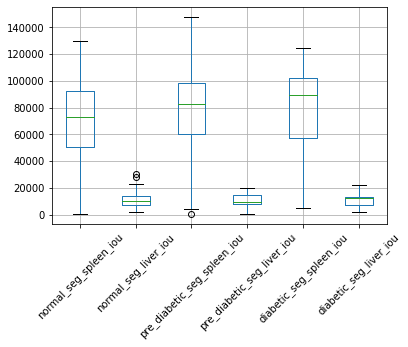

In [42]:
dfs[['normal_seg_spleen_iou', 'normal_seg_liver_iou', 'pre_diabetic_seg_spleen_iou', 'pre_diabetic_seg_liver_iou', 'diabetic_seg_spleen_iou', 'diabetic_seg_liver_iou']].boxplot(rot=45)

t,p = stats.ttest_ind(dfs['normal_seg_spleen_iou'].dropna().values, dfs[ 'pre_diabetic_seg_spleen_iou'].dropna().values)

print('normal_seg_spleen_iou vs pre_diabetic_seg_spleen_iou')
print('t:', t)
print('p:', p)
print('\n')

t,p = stats.ttest_ind(dfs['normal_seg_spleen_iou'].dropna().values, dfs[ 'diabetic_seg_spleen_iou'].dropna().values)
print('normal_seg_spleen_iou vs diabetic_seg_spleen_iou')
print('t:', t)
print('p:', p)
print('\n')

t,p = stats.ttest_ind(dfs['pre_diabetic_seg_spleen_iou'].dropna().values, dfs[ 'diabetic_seg_spleen_iou'].dropna().values)
print('pre_diabetic_seg_spleen_iou vs diabetic_seg_spleen_iou')
print('t:', t)
print('p:', p)
print('\n')

t,p = stats.ttest_ind(dfs['normal_seg_liver_iou'].dropna().values, dfs[ 'pre_diabetic_seg_liver_iou'].dropna().values)
print('normal_seg_liver_iou vs pre_diabetic_seg_liver_iou')
print('t:', t)
print('p:', p)
print('\n')

t,p = stats.ttest_ind(dfs['normal_seg_liver_iou'].dropna().values, dfs[ 'diabetic_seg_liver_iou'].dropna().values)
print('normal_seg_liver_iou vs diabetic_seg_liver_iou')
print('t:', t)
print('p:', p)
print('\n')

t,p = stats.ttest_ind(dfs['pre_diabetic_seg_liver_iou'].dropna().values, dfs[ 'diabetic_seg_liver_iou'].dropna().values)
print('pre_diabetic_seg_liver_iou vs diabetic_seg_liver_iou')
print('t:', t)
print('p:', p)
print('\n')